In [ ]:
!pip install pytorch-msssim

In [114]:
import os

# print(os.getcwd())
os.chdir('/workspace/NN')
# print(os.getcwd())
import numpy as np
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm, trange
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchvision import transforms
import pandas as pd
import seaborn as sns
from torchmetrics.image.ssim import StructuralSimilarityIndexMeasure
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

orig_ssim = 0.7124563455581665

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [2]:


# Настройка параметров
data_dir = './dataset/train'  # Путь к директории с изображениями
test_dir = './dataset/test'  # Путь к директории с изображениями
batch_size = 24  # Размер мини-батча
num_workers = 4  # Количество потоков для загрузки данных
shuffle = True  # Перемешивание данных

# Преобразования данных
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера изображений
    transforms.ToTensor(),  # Преобразование изображений в тензоры
    # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Нормализация
    # transforms.Lambda(lambd=lambda x: x / 255.0)
])


# Кастомный Dataset для бесклассовой загрузки изображений
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        # Получаем список всех файлов в директории
        self.image_paths = [os.path.join(root_dir, fname) for fname in os.listdir(root_dir) if
                            fname.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Загрузка изображения по индексу
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Открываем изображение и конвертируем в RGB

        if self.transform:
            image = self.transform(image)  # Применяем преобразования

        return image


# Создание Dataset и DataLoader
dataset = ImageDataset(root_dir=data_dir, transform=transform)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

x_train, x_val = train_test_split(dataset, train_size=0.8,
                                  random_state=42)
train_dataloader = DataLoader(dataset=x_train, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
val_dataloader = DataLoader(dataset=x_val, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

test_dataset = ImageDataset(root_dir=test_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

# Пример использования DataLoader
print(len(x_train), len(x_val), len(test_dataset), len(dataset))


163 41 21 204


In [141]:
bt = 2


class CNNImageCodec(nn.Module):
    # def __init__(self, add_noize: bool = False):
    #     super().__init__()
    #     self.encoder = nn.Sequential(
    #         nn.Conv2d(3, 128, 7, padding=3, stride=2),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(128),
    #         # nn.AvgPool2d(2),
    #
    #         nn.Conv2d(128, 32, 5, padding=2, stride=2),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(32),
    #         # nn.AvgPool2d(2),
    #
    #         nn.Conv2d(32, 16, 3, padding=1, stride=2),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(16),
    #         # nn.AvgPool2d(2),
    #         # nn.Linear(16 * 16 * 16, 16 * 16 * 16),
    #         # nn.ReLU(),
    #         # nn.BatchNorm2d(16),
    #     )
    #     self.encoder_linear = nn.Sequential(
    #         nn.Linear(16 * 16 * 16, 16 * 16 * 16),
    #         nn.ReLU(),
    #         nn.BatchNorm1d(16 * 16 * 16),
    #     )
    #     self.decode_liner = nn.Sequential(
    #         nn.Linear(2048, 16 * 16 * 16),
    #         nn.ReLU(),
    #         nn.BatchNorm1d(16 * 16 * 16),
    #     )
    #     self.decoder = nn.Sequential(
    #
    #         # nn.Upsample(scale_factor=2),
    #         nn.ConvTranspose2d(16, 16, 3, padding=1, stride=2),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(16),
    #         # nn.Upsample(scale_factor=2),
    #         nn.ConvTranspose2d(16, 32, 5, padding=1, stride=2),
    #         # nn.Conv2d(16, 32, 5, padding=2),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(32),
    #
    #         # nn.Upsample(scale_factor=2),
    #         # nn.Conv2d(32, 3, 7, padding=3),
    #         nn.ConvTranspose2d(32, 3, 7, padding=2, stride=2, output_padding=1),
    #         nn.Sigmoid()
    #         # nn.Softmax(dim=1),
    #     )

    def __init__(self, n1M1=128, n2M1=32, n3M1=16, latent_space=16*16*16, add_noize=False):
        super(CNNImageCodec, self).__init__()
        self.add_noize = add_noize
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n1M1, kernel_size=7, stride=2, padding=3),
            nn.ReLU(),
            # nn.AvgPool2d(2),
            nn.BatchNorm2d(n1M1),
            nn.Conv2d(n1M1, n2M1, kernel_size=5, stride=2, padding=2),
            nn.ReLU(),
            # nn.AvgPool2d(2),
            nn.BatchNorm2d(n2M1),
            nn.Conv2d(n2M1, n3M1, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            # nn.AvgPool2d(2),
            nn.BatchNorm2d(n3M1),
        )

        # self.encoder_linear = nn.Sequential(
        #     nn.Linear(n3M1 * 16*16, latent_space),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(latent_space),
        # )
        # self.decode_liner = nn.Sequential(
        #     nn.Linear(latent_space, n3M1 * 16*16),
        #     nn.ReLU(),
        #     nn.BatchNorm1d(n3M1 * 16*16),
        # )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n3M1, n2M1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n2M1),
            nn.ConvTranspose2d(n2M1, n1M1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(n1M1),
            nn.ConvTranspose2d(n1M1, 3, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        batch_size = x.size(0)
        conv_res: torch.Tensor = self.encoder(x)
        conv_size = conv_res.size()
        if self.add_noize:
            conv_res.device
            maxt = conv_res.max().to(conv_res.device)
            # torch.FloatTensor(16,16,16).uniform_(-1.0/pow(2, bt+1), high=1.0/pow(2, bt+1))
            conv_res = conv_res + maxt*(torch.FloatTensor(16,16,16).uniform_(-1.0/pow(2, bt+1), 1.0/pow(2, bt+1)).to(conv_res.device))

        # latent = self.encoder_linear(conv_res.view(batch_size, -1))
        # after_latent = self.decode_liner(latent).view(*conv_size)
        # print(latent.size())
        after_latent = latent = conv_res

        res = self.decoder(after_latent)  # .view(*conv_size)
        return res, latent

In [142]:
def vae_loss_function(recon_x, x, logvar, KL_weight=1):
    MSE = nn.functional.mse_loss(recon_x, x, reduction='none')
    MSE = torch.div(MSE, torch.numel(x))
    MSE = torch.sum(MSE)
    KLD = -0.5 * torch.sum(1 + logvar - logvar.exp())
    KLD = torch.div(KLD, x.shape[0])
    return MSE, KLD


def PSNR(y_true, y_pred):
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return 100.0
    max_pixel = 1.0
    return 20 * torch.log10(max_pixel / torch.sqrt(mse))


def kl_divergence(input_image, reconstructed_image):
    # Вычисление распределений вероятностей для изображений
    input_image_probs = F.softmax(input_image.flatten(start_dim=1), dim=-1)
    reconstructed_image_probs = F.softmax(reconstructed_image.flatten(start_dim=1), dim=-1)

    # KL-дивергенция для изображений
    image_kl = F.kl_div(
        input_image_probs.log(),
        reconstructed_image_probs,
        reduction="batchmean"
    )

    return image_kl.item()


def calculate_ssim(input_image, output_image):
    assert input_image.shape == output_image.shape, "Размеры входного и выходного изображений должны совпадать."
    # Создание экземпляра метрики SSIM
    ssim_metric = StructuralSimilarityIndexMeasure(data_range=1.0).to(
        device)  # Ожидается, что изображения нормализованы [0, 1]
    if input_image.max() > 1.0:
        input_image = input_image / 255.0
    if output_image.max() > 1.0:
        output_image = output_image / 255.0
    ssim_score = ssim_metric(input_image, output_image)
    return ssim_score.mean().item()


def calculate_bpp_from_tensor(encoded_tensor, image_shape):
    bits_per_element = encoded_tensor.element_size() * 8  # Размер одного элемента в битах
    total_bits = encoded_tensor.numel() * bits_per_element  # Общее количество бит
    num_pixels = image_shape[1] * image_shape[2]
    bpp = total_bits / num_pixels
    return bpp


def get_metrics(input_img, recovered_mg, latent_spase, container: dict[str, list[float]], stage='train/'):
    mse_loss, kld_loss = vae_loss_function(recovered_mg, input_img, latent_spase)
    container[f'{stage}kld_loss'].append(kld_loss.item())
    container[f'{stage}kld'].append(kl_divergence(input_img, recovered_mg))
    container[f'{stage}mse_loss'].append(mse_loss.item())
    container[f'{stage}SSID'].append(
        ms_ssim(input_img, recovered_mg, data_range=1, size_average=False, win_size=7).mean().item())
    container[f'{stage}SSID_1'].append(calculate_ssim(input_img, recovered_mg))
    container[f'{stage}PSNR'].append(PSNR(input_img, recovered_mg).item())
    container[f'{stage}bpp'].append(latent_spase.size()[1] / (input_img.size()[2] * input_img.size()[3]))
    container[f'{stage}bpp_1'].append(calculate_bpp_from_tensor(latent_spase[0], input_img.size()[1:]) / 24)

    return container, kld_loss, mse_loss



In [143]:

scheduler_epochs_step = 400

model = CNNImageCodec(add_noize=True).cpu()
optimizer = torch.optim.Adam(model.parameters(), lr=3 * 10e-4)
loss_fn = vae_loss_function
scheduler = StepLR(optimizer, step_size=scheduler_epochs_step, gamma=0.1)

In [144]:
for images in train_dataloader:
    with torch.no_grad():
        model = model.cpu()
        test, latent = model(images.cpu())
        assert test.size() == images.size(), f"{test.size()} {images.size()}"
        assert images.max() <= 1 and images.min() >= 0, f"min max items {images.min()} {images.max()}"

        test_loss = loss_fn(images, test, latent)
        bits_per_element = latent[0].element_size() * 6  # Размер одного элемента в битах
        total_bits = latent[0].numel() * bits_per_element  # Общее количество бит
        num_pixels = images.size()[2] * images.size()[3]
        bpp = total_bits / num_pixels
        print(bpp / 24, "|", latent[0].numel(), bits_per_element, "|", num_pixels)

        break  # Остановка после одного батча для примера

0.25 | 4096 24 | 16384


In [145]:
model = model.to(device)

In [146]:
def learn_callback(curr_model, metrics_container, curr_epoch):
    eval_loss = validation(curr_model, metrics_container)
    KLD_loss = metrics_container['val/kld']
    mse_loss = metrics_container['val/mse_loss']
    ssim_loss = metrics_container['val/SSID_1']
    bpp = metrics_container['val/bpp_1']
    if curr_epoch % 50 == 0:
        print(
            f'Epoch: {epoch + 1:02} | mse={mse_loss[-1]:.5f}|{eval_loss:.5f}, kld={KLD_loss[-1]:.5f} ssim={ssim_loss[-1]:.5f}, bpp={bpp[-1]:.5f}')


def train_epoch(curr_model, curr_dataloader, callback_fun, metrics_container, curr_epoch):
    curr_model.train()
    # losses = []

    for images_batch in curr_dataloader:
        optimizer.zero_grad()
        images_batch = images_batch.to(device)
        recovered_images, latent = curr_model(images_batch)
        # loss_fn(recovered_images, images_batch, latent)
        metrics_container, loss_KDE, loss_mse = get_metrics(images_batch, recovered_images, latent, metrics_container)
        # loss_KDE.backward()
        loss_mse.backward()
        optimizer.step()
        # losses.append(loss_KDE.item())
    model.train()
    callback_fun(curr_model, metrics_container, curr_epoch=curr_epoch)
    return metrics_container


def validation(curr_model, metrics_container):
    global val_dataloader
    model.eval()
    losses = []
    with torch.no_grad():
        for images_batch in val_dataloader:
            images_batch = images_batch.to(device)
            recovered_images, latent = curr_model(images_batch)
            metrics_container, loss_KDE, loss_mse = get_metrics(images_batch, recovered_images, latent, metrics_container, stage='val/')
            # loss_mse, loss_KLD = loss_fn(recovered_images, images_batch, latent)
            losses.append(loss_mse.item())
    return sum(losses) / len(losses)



In [147]:

metrics_container = {
    'val/bpp': [],
    'val/kld_loss': [],
    'val/mse_loss': [],
    'val/PSNR': [],
    'val/SSID': [],
    'val/kld': [],
    "val/SSID_1": [],
    "val/bpp_1": [],
    'train/bpp': [],
    'train/kld_loss': [],
    'train/mse_loss': [],
    'train/PSNR': [],
    'train/SSID': [],
    'train/kld': [],
    "train/SSID_1": [],
    "train/bpp_1": [],
}
validation(model, metrics_container)
epochs_count = 2000
for epoch in trange(epochs_count + 1, desc='Total', ):
    metrics_container = train_epoch(model, train_dataloader, learn_callback, metrics_container, epoch)
    scheduler.step()
    # break
validation(model, metrics_container)



Total:   0%|          | 0/2001 [00:00<?, ?it/s]

Epoch: 01 | mse=0.07117|0.07033, kld=0.01715 ssim=0.13219, bpp=0.33333
Epoch: 51 | mse=0.00769|0.00733, kld=0.00388 ssim=0.61873, bpp=0.33333
Epoch: 101 | mse=0.00498|0.00489, kld=0.00245 ssim=0.70491, bpp=0.33333
Epoch: 151 | mse=0.00414|0.00417, kld=0.00206 ssim=0.73236, bpp=0.33333
Epoch: 201 | mse=0.00363|0.00365, kld=0.00178 ssim=0.74322, bpp=0.33333
Epoch: 251 | mse=0.00317|0.00318, kld=0.00155 ssim=0.80202, bpp=0.33333
Epoch: 301 | mse=0.00280|0.00290, kld=0.00138 ssim=0.81997, bpp=0.33333
Epoch: 351 | mse=0.00286|0.00267, kld=0.00145 ssim=0.81616, bpp=0.33333
Epoch: 401 | mse=0.00222|0.00220, kld=0.00110 ssim=0.85349, bpp=0.33333
Epoch: 451 | mse=0.00230|0.00214, kld=0.00116 ssim=0.84834, bpp=0.33333
Epoch: 501 | mse=0.00207|0.00211, kld=0.00102 ssim=0.84452, bpp=0.33333
Epoch: 551 | mse=0.00204|0.00208, kld=0.00102 ssim=0.85227, bpp=0.33333
Epoch: 601 | mse=0.00237|0.00211, kld=0.00119 ssim=0.85378, bpp=0.33333
Epoch: 651 | mse=0.00196|0.00205, kld=0.00098 ssim=0.86147, bpp=0.

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/local/lib/python3.11/multiprocessing/connection.py", line 178, in close
    self._close()
  File "/usr/local/lib/python3.11/multiprocessing/connection.py", line 377, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Epoch: 1651 | mse=0.00180|0.00198, kld=0.00089 ssim=0.86572, bpp=0.33333
Epoch: 1701 | mse=0.00203|0.00201, kld=0.00103 ssim=0.87161, bpp=0.33333
Epoch: 1751 | mse=0.00211|0.00202, kld=0.00105 ssim=0.86441, bpp=0.33333
Epoch: 1801 | mse=0.00198|0.00200, kld=0.00098 ssim=0.87068, bpp=0.33333
Epoch: 1851 | mse=0.00207|0.00202, kld=0.00103 ssim=0.86008, bpp=0.33333
Epoch: 1901 | mse=0.00207|0.00202, kld=0.00103 ssim=0.86312, bpp=0.33333
Epoch: 1951 | mse=0.00179|0.00198, kld=0.00087 ssim=0.86640, bpp=0.33333
Epoch: 2001 | mse=0.00190|0.00199, kld=0.00094 ssim=0.86534, bpp=0.33333


0.002007868140935898

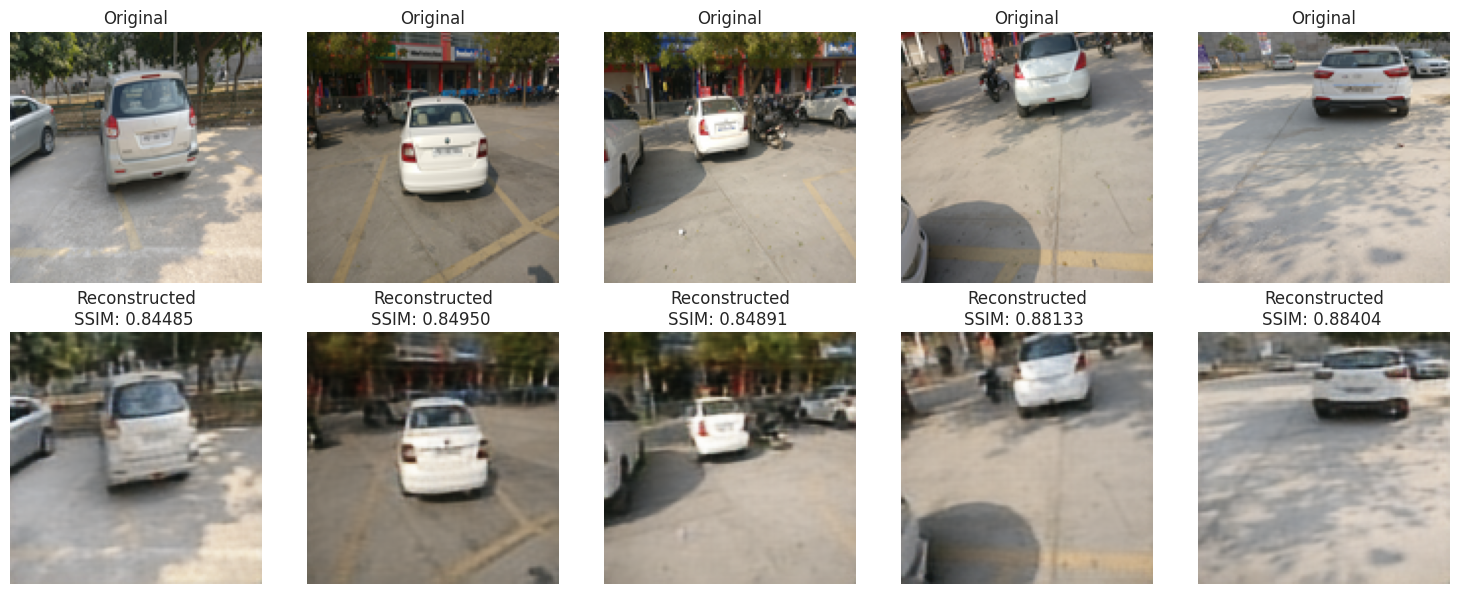

0.8663543462753296


In [100]:
# %matplotlib inline
#

NumImagesToShow = 5
# Visualize results with larger plots
fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер всей фигуры (ширина x высота в дюймах)

for images in test_dataloader:
    with torch.no_grad():
        model = model.to(device)
        recovered_img, latent = model(images.to(device))
        images = images.cpu()
        recovered_img = recovered_img.cpu()
        for i in range(NumImagesToShow):
            # Original images
            ax1 = fig.add_subplot(2, NumImagesToShow, i + 1)
            ax1.imshow(images[i].permute(1, 2, 0).cpu().numpy())
            ax1.axis('off')
            ax1.set_title("Original", fontsize=12)

            # Reconstructed images
            ax2 = fig.add_subplot(2, NumImagesToShow, NumImagesToShow + i + 1)
            ax2.imshow(recovered_img[i].permute(1, 2, 0).cpu().numpy())
            ax2.axis('off')
            psnr_value = calculate_ssim(images[i:i + 1], recovered_img[i:i + 1])
            ax2.set_title(f"Reconstructed\nSSIM: {psnr_value:.5f} ", fontsize=12)
        break

# Show the plot
plt.tight_layout()  # Для автоматического выравнивания графиков
plt.show()
modified_ssim = calculate_ssim(images, recovered_img)
print(modified_ssim)
torch.save(model.state_dict(), f"weights/modification_autoencoder_{epoch}_ssim_{modified_ssim:.05f}.pth")
assert modified_ssim - orig_ssim > 0.05, f"Недостаточно по качеству {modified_ssim - orig_ssim} < 0.05"

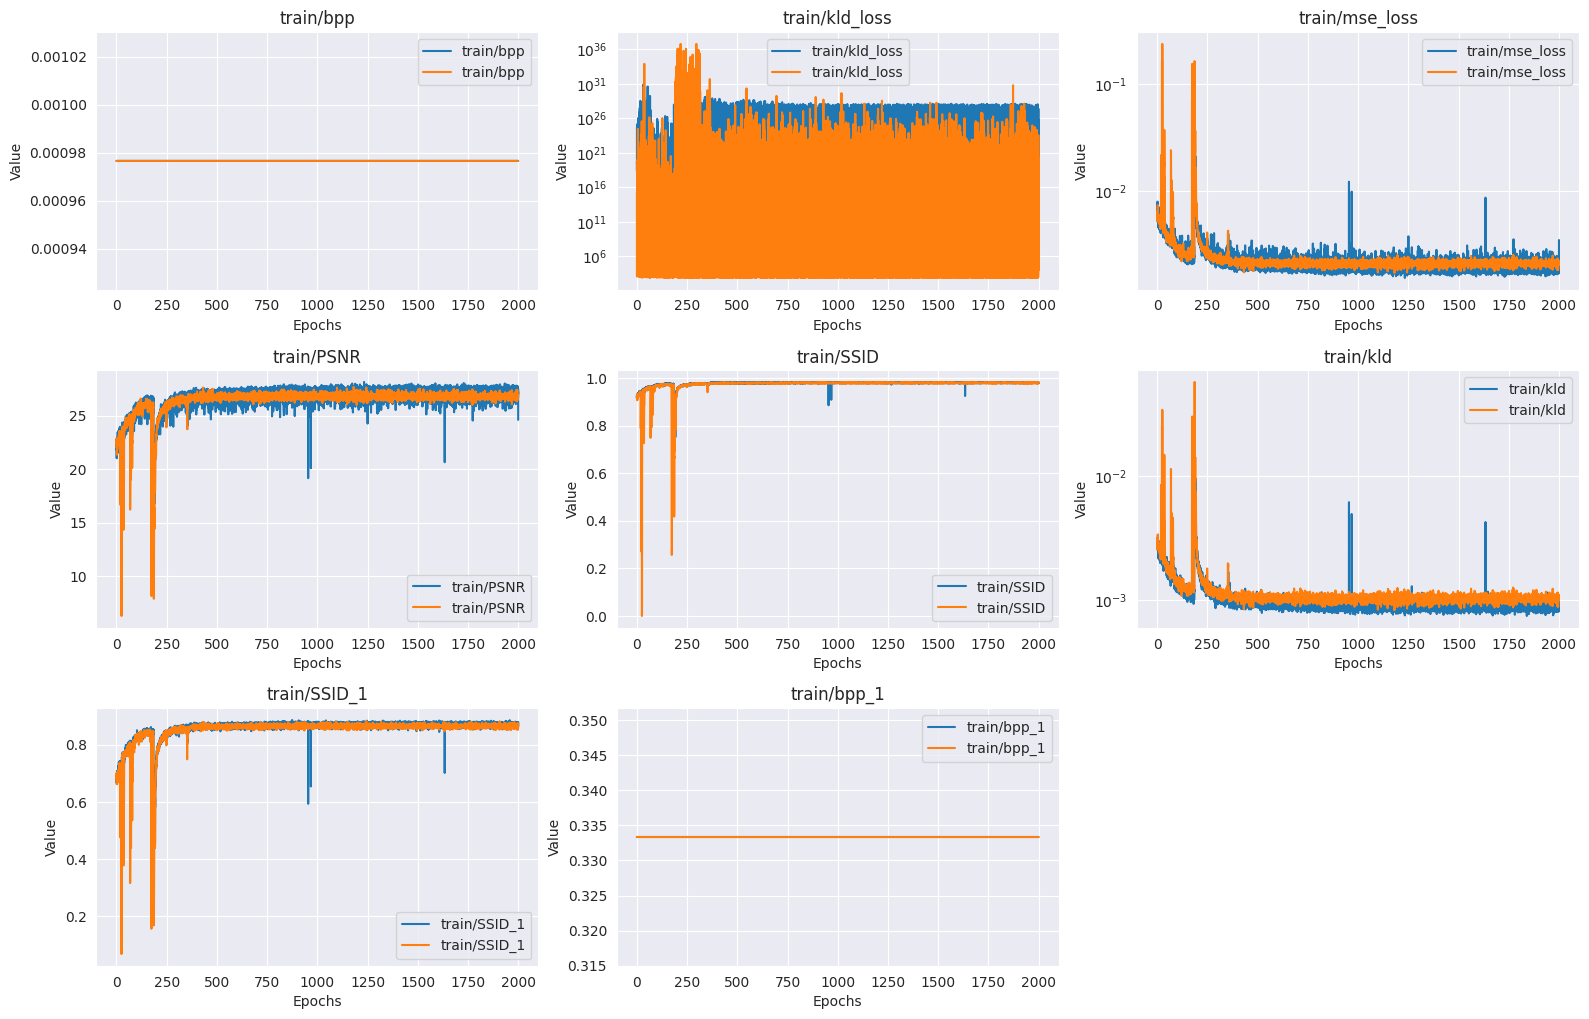

In [101]:
# epochs_count = 500
# Построение графиков
plt.figure(figsize=(16, 20))  # Размер фигуры
num_metrics = len(metrics_container)  # Количество метрик

for i, (key, values) in enumerate((filter(lambda i: i[0].startswith('train/') , metrics_container.items())), 1):
    plt.subplot((num_metrics + 2) // 3, 3, i)  # Распределяем графики по строкам и столбцам
    plt.plot([i*epochs_count / len(values) for i in range(len(values))], values, label=key)  # Линия графика
    # str.removeprefix()
    validation_values = metrics_container[f'val/{key.removeprefix("train/")}']
    plt.plot([i*epochs_count / len(validation_values) for i in range(len(validation_values))], validation_values, label=key)  # Линия графика
    plt.title(key)  # Название графика
    plt.xlabel('Epochs')  # Подпись оси X
    plt.ylabel('Value')  # Подпись оси Y
    # ax2.set_yscale('log')
    # ax2.set_xscale('log')
    # plt.xscale('log')
    if any([i in key for i in ['mse', 'kld']]):
        plt.yscale('log')

    plt.grid(True)  # Сетка
    plt.legend()  # Легенда

# Отображение всех графиков
plt.tight_layout()  # Компактное расположение
plt.show()

In [314]:
import os
import math
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import imghdr
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim

# Constants
testfolder = './dataset/test/'
trainfolder = './dataset/train/'
w, h = 128, 128
LoadModel = 0
bt = 2
epochs = 2000
batch_sizeM1 = 24
n1M1, n2M1, n3M1 = 128, 32, 16
NumImagesToShow = 5
b = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load images from folder
def LoadImagesFromFolder(foldername):
    dir_list = os.listdir(foldername)
    images = []
    for name in dir_list:
        fullname = foldername + name
        filetype = imghdr.what(fullname)
        if filetype is not None:
            image = Image.open(fullname).resize((w, h))
            images.append(np.array(image))
    images = np.array(images, dtype=np.float32) / 255.0
    return torch.tensor(images).permute(0, 3, 1, 2)  # Convert to PyTorch format


# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, n1M1, kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(n1M1, n2M1, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.AvgPool2d(2),
            nn.Conv2d(n2M1, n3M1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AvgPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n3M1, n2M1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(n2M1, n1M1, kernel_size=5, stride=2, padding=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(n1M1, 3, kernel_size=7, stride=2, padding=3, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


# Train autoencoder
def train_model(train_images):
    old_model = Autoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(old_model.parameters(), lr=1e-3)

    train_images = train_images.to(device)
    for epoch in range(epochs):
        old_model.train()
        optimizer.zero_grad()
        _, outputs = old_model(train_images)
        loss = criterion(outputs, train_images)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    torch.save(old_model.state_dict(), "weights/orig_autoencoder.pth")
    return old_model


# Main function
if __name__ == "__main__":
    # Load test and train images
    xtest = LoadImagesFromFolder(testfolder)
    xtrain = LoadImagesFromFolder(trainfolder)

    # Train or load model
    if LoadModel == 0:
        old_model = train_model(xtrain)
    else:
        old_model = Autoencoder().to(device)
        old_model.load_state_dict(torch.load("weights/orig_autoencoder.pth"))
        old_model.eval()

    xtest = xtest.to(device)
    with torch.no_grad():
        encoded, decoded = old_model(xtest)



Epoch [100/2000], Loss: 0.0115
Epoch [200/2000], Loss: 0.0094
Epoch [300/2000], Loss: 0.0083
Epoch [400/2000], Loss: 0.0076
Epoch [500/2000], Loss: 0.0072
Epoch [600/2000], Loss: 0.0069
Epoch [700/2000], Loss: 0.0068
Epoch [800/2000], Loss: 0.0067
Epoch [900/2000], Loss: 0.0065
Epoch [1000/2000], Loss: 0.0063
Epoch [1100/2000], Loss: 0.0064
Epoch [1200/2000], Loss: 0.0058
Epoch [1300/2000], Loss: 0.0057
Epoch [1400/2000], Loss: 0.0054
Epoch [1500/2000], Loss: 0.0053
Epoch [1600/2000], Loss: 0.0053
Epoch [1700/2000], Loss: 0.0053
Epoch [1800/2000], Loss: 0.0052
Epoch [1900/2000], Loss: 0.0050
Epoch [2000/2000], Loss: 0.0051


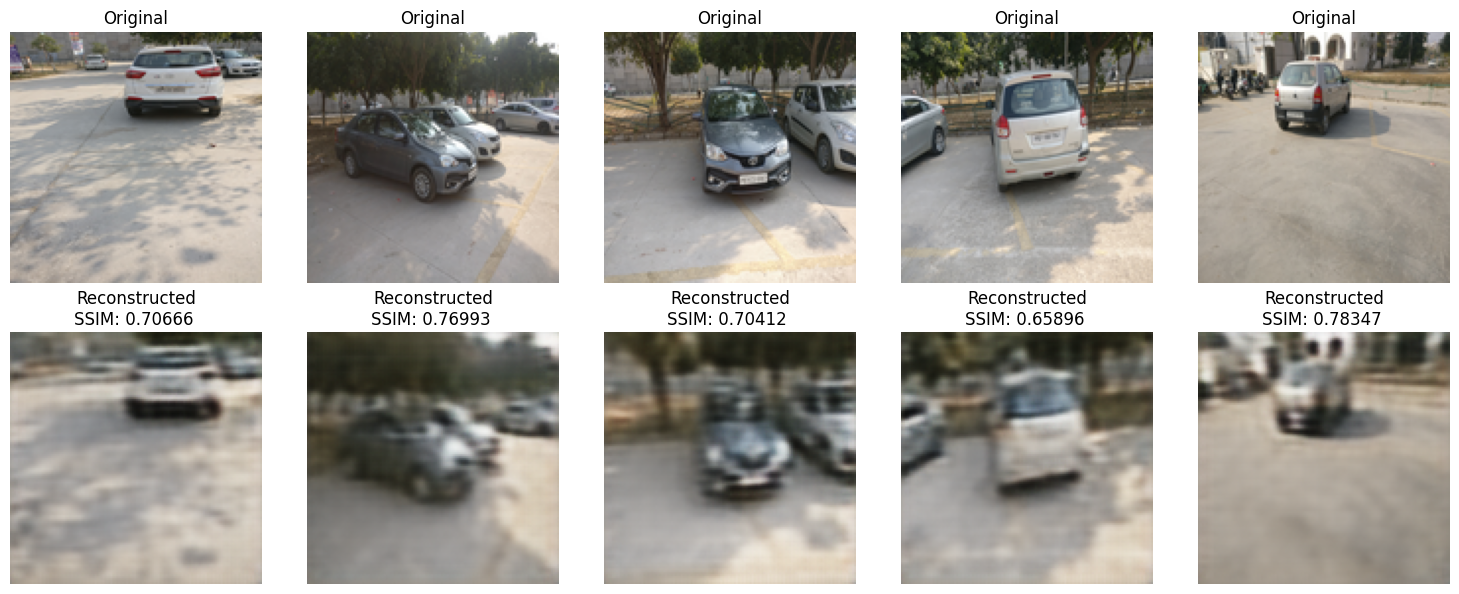

0.7124563455581665


In [322]:
# Visualize results with larger plots
fig = plt.figure(figsize=(15, 6))  # Устанавливаем размер всей фигуры (ширина x высота в дюймах)
for i in range(NumImagesToShow):
    # Original images
    ax1 = fig.add_subplot(2, NumImagesToShow, i + 1)
    ax1.imshow(xtest[i].permute(1, 2, 0).cpu().numpy())
    ax1.axis('off')
    ax1.set_title("Original", fontsize=12)

    # Reconstructed images
    ax2 = fig.add_subplot(2, NumImagesToShow, NumImagesToShow + i + 1)
    ax2.imshow(decoded[i].permute(1, 2, 0).cpu().numpy())
    ax2.axis('off')
    psnr_value = calculate_ssim(xtest[i:i + 1], decoded[i:i + 1])
    ax2.set_title(f"Reconstructed\nSSIM: {psnr_value:.5f} ", fontsize=12)

# Show the plot
plt.tight_layout()  # Для автоматического выравнивания графиков
plt.show()
orig_ssim = calculate_ssim(xtest, decoded)
print(orig_ssim)


